In [184]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from datetime import datetime as dt
import datetime
import seaborn as sns

import MP_functions as dfutil

# Importing & Loading Data

Make sure to unzip the pickles.zip into the root folder for the project.

In [9]:
# from load_pickles import df as pickle
df = dfutil.open_dataframe_pickle('MTA_DATA_SPRING_2014_to_2016_FULL.pickle')
dtp = dfutil.open_dataframe_pickle('daily_throughput.pickle')
htp = dfutil.open_dataframe_pickle('hourly_throughput.pickle')

# Functions

In [10]:
def get_daily_counts(row, max_counter, cols):
    """
    cols - a list of columns to compute the difference from with format [x, y] = x-y
    """
    counter = row[cols[0]] - row[cols[1]]
    if counter < 0:
        # May be counter is reversed?
        counter = -counter
    if counter > max_counter:
#         print(row[cols[0]], row[cols[1]])
        counter = min(row[cols[0]], row[cols[1]])
    if counter > max_counter:
        # Check it again to make sure we are not giving a counter that's too big
        return 0
    return counter

In [11]:
def cleanData(frame):
    # Strip whitespace from column names
    frame.columns = [s.strip() for s in frame.columns.values]

    # Create datetime column with datetime datatype
    frame['Datetime'] = pd.to_datetime(frame.DATE + ' ' + frame.TIME,
                                        format = '%m/%d/%Y %H:%M:%S')
    frame['Day_of_week'] = frame['Datetime'].apply(lambda row: row.strftime("%A"))
    
    # Chain methods together to further clean data:
        # drop old date and time columns
        # rename columns
    
    dict_col_rename = {'C/A' : 'C_A', 'UNIT' : 'Unit', 'STATION' : 'Station', 'LINENAME' : 'Linename',
                      'DIVISION' : 'Division', 'DESC' : 'Desc', 'ENTRIES' : 'Entries', 'EXITS' : 'Exits',
                      'DATE' : 'Date'}    

    frame2 = frame.rename(columns = dict_col_rename)
    
    # Check uniqueness of rows/indexes by getting counts.
    (frame2
     .groupby(['C_A', 'Unit', 'SCP', 'Station', 'Datetime'])
     .count() #.Entries.count()
     .reset_index()
     .sort_values('Entries', ascending = False)
    )
    
    # Drop duplicates.
    return frame2.drop_duplicates(subset=['C_A', 'Unit', 'SCP', 'Station', 'Datetime'])
    
    

In [12]:
def calcDailyThroughput(frame):
    
    # group daily entries and daily exits
    daily_entries = (frame
                      .groupby(['C_A', 'Unit', 'SCP', 'Station', 'Date'])
                      .Entries
                      .first()
                      .reset_index()
                    )

    daily_exits = (frame
                    .groupby(['C_A', 'Unit', 'SCP', 'Station', 'Date'])
                    .Exits
                    .first()
                    .reset_index()
                   )
    
    # Calculate the differences by day
    daily_entries[["Prev_date", "Prev_entries"]] = (daily_entries
                                                     .groupby(["C_A", "Unit", "SCP", "Station"])["Date", "Entries"]
                                                     .transform(lambda grp: grp.shift(1)))

    daily_exits[["Prev_date", "Prev_exits"]]   = (daily_exits
                                                   .groupby(["C_A", "Unit", "SCP", "Station"])["Date", "Exits"]
                                                   .transform(lambda grp: grp.shift(1)))

    # Drop all the null values generated above
    daily_entries.dropna(subset=["Prev_date"], axis=0, inplace=True)
    daily_exits.dropna(subset=["Prev_date"], axis=0, inplace=True)


    daily_entries["Daily_Entries"] = daily_entries.apply(get_daily_counts, axis=1, args=(1000000, ['Entries', 'Prev_entries']))
    daily_exits["Daily_Exits"] = daily_exits.apply(get_daily_counts, axis=1, args=(1000000, ['Exits', 'Prev_exits']))
    
    daily = pd.merge(daily_entries, daily_exits, on=['C_A','Unit','SCP', 'Station', 'Date', 'Prev_date'])
    daily['Total_throughput'] = daily['Daily_Entries'] + daily['Daily_Exits']
    
    return (daily
             .groupby(['Station', 'Date'])
             .sum()
            #  .sort_values(by=['Total_throughput'], ascending=False)
             .loc[:,['Daily_Entries', 'Daily_Exits', 'Total_throughput']]
            #  .frame()
            )

In [13]:
def calcHourThroughput(frame):
    shift = frame.copy()

    shift[['Datetime_Prev', 'Entries_Prev', 'Exits_Prev']] = (shift
                .groupby(['C_A', 'Unit', 'SCP', 'Station'])['Datetime', 'Entries', 'Exits']
                .transform(lambda grp: grp.shift(1)))
    
    shift['Entries'] = shift['Entries'] - shift['Entries_Prev']
    shift['Exits'] = shift['Exits'] - shift['Exits_Prev']
    shift = shift.dropna(how = 'any')
    
    shift['Throughput'] = shift['Entries'] + shift['Exits']
    
    return shift.loc[:,['Station','Datetime','Throughput']]

In [14]:
# Make note to save and open pickles here:
# dfutil.save_dataframe_as_pickle(df,'MTA_DATA_SPRING_2014_to_2016_FULL.pickle')
# df_pickle = dfutil.open_dataframe_pickle('MTA_DATA_SPRING_2014_to_2016_FULL.pickle') # returns a df

# Function Testing

In [15]:
# To find hour through put 
# test_df3.groupby(['Station', 'Datetime']).sum()

In [16]:
df.head()

,C_A,Unit,SCP,Station,Linename,Division,Date,TIME,Desc,Entries,Exits,Datetime,Day_of_week
0,A002,R051,02-00-00,59 ST,NQR456,BMT,06/18/2016,00:00:00,REGULAR,5704958,1934814,2016-06-18 00:00:00,Saturday
1,A002,R051,02-00-00,59 ST,NQR456,BMT,06/18/2016,04:00:00,REGULAR,5704958,1934829,2016-06-18 04:00:00,Saturday
2,A002,R051,02-00-00,59 ST,NQR456,BMT,06/18/2016,08:00:00,REGULAR,5704958,1934886,2016-06-18 08:00:00,Saturday
3,A002,R051,02-00-00,59 ST,NQR456,BMT,06/18/2016,12:00:00,REGULAR,5704958,1934993,2016-06-18 12:00:00,Saturday
4,A002,R051,02-00-00,59 ST,NQR456,BMT,06/18/2016,16:00:00,REGULAR,5704958,1935069,2016-06-18 16:00:00,Saturday


In [18]:
htp.head()

,Station,Datetime,Throughput
1,59 ST,2016-06-18 04:00:00,15.0
2,59 ST,2016-06-18 08:00:00,57.0
3,59 ST,2016-06-18 12:00:00,107.0
4,59 ST,2016-06-18 16:00:00,76.0
5,59 ST,2016-06-18 20:00:00,63.0


In [150]:
htp_mean = htp.groupby(['Station', 'Datetime']).mean().reset_index()

In [151]:
Morning = 

htp_mean.

,Station,Datetime,Throughput
0,1 AVE,2015-02-28 03:00:00,-64298.1
1,1 AVE,2015-02-28 07:00:00,100.8
2,1 AVE,2015-02-28 11:00:00,456.4
3,1 AVE,2015-02-28 15:00:00,828.9
4,1 AVE,2015-02-28 19:00:00,1073.3


In [103]:
# dtp['Day_of_week'] = #(pd.to_datetime(dtp.reset_index()['Date'], format = '%m/%d/%Y'))

In [137]:
dtp = dtp.reset_index()
dtp['Day_of_week'] = pd.to_datetime(dtp['Date'], format = '%m/%d/%Y').apply(lambda row: row.strftime("%A"))

dtp_sum = dtp.groupby(['Day_of_week','Station'])['Total_throughput'].sum().reset_index()
pivot = dtp_sum.pivot(index='Station', columns='Day_of_week', values = 'Total_throughput')

monday = pivot['Monday'].sort_values(ascending=False).index.values
tuesday = pivot['Tuesday'].sort_values(ascending=False).index.values
wednesday = pivot['Wednesday'].sort_values(ascending=False).index.values
thursday = pivot['Thursday'].sort_values(ascending=False).index.values
friday = pivot['Friday'].sort_values(ascending=False).index.values
saturday = pivot['Saturday'].sort_values(ascending=False).index.values
sunday = pivot['Sunday'].sort_values(ascending=False).index.values

df = pd.DataFrame({'Monday': monday,
                  'Tuesday': tuesday,
                  'Wednesday': wednesday,
                  'Thursday': thursday,
                  'Friday': friday,
                  'Saturday': saturday,
                  'Sunday': sunday})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13d8c8978>]], dtype=object)

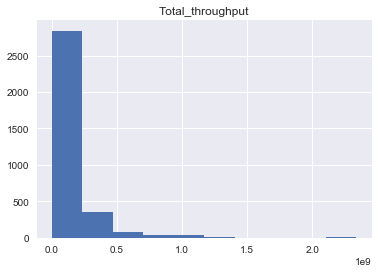

In [185]:
%matplotlib inline
dtp_sum.hist()

In [221]:
dtp_mean = dtp.groupby(['Day_of_week','Station'])['Total_throughput'].mean().reset_index()
pivot = dtp_mean.pivot(index='Station', columns='Day_of_week', values = 'Total_throughput')

monday = pivot['Monday'].sort_values(ascending=False).index.values
tuesday = pivot['Tuesday'].sort_values(ascending=False).index.values
wednesday = pivot['Wednesday'].sort_values(ascending=False).index.values
thursday = pivot['Thursday'].sort_values(ascending=False).index.values
friday = pivot['Friday'].sort_values(ascending=False).index.values
saturday = pivot['Saturday'].sort_values(ascending=False).index.values
sunday = pivot['Sunday'].sort_values(ascending=False).index.values

df = pd.DataFrame({'Monday': monday,
                  'Tuesday': tuesday,
                  'Wednesday': wednesday,
                  'Thursday': thursday,
                  'Friday': friday,
                  'Saturday': saturday,
                  'Sunday': sunday})

In [ ]:
pivot

In [228]:
df.head(20)

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,34 ST-PENN STA,34 ST-PENN STA,34 ST-PENN STA,34 ST-PENN STA,34 ST-PENN STA,34 ST-PENN STA,34 ST-PENN STA
1,FULTON ST,FULTON ST,FULTON ST,FULTON ST,FULTON ST,FULTON ST,FULTON ST
2,34 ST-HERALD SQ,34 ST-HERALD SQ,34 ST-HERALD SQ,34 ST-HERALD SQ,34 ST-HERALD SQ,34 ST-HERALD SQ,34 ST-HERALD SQ
3,CANAL ST,CANAL ST,CANAL ST,CANAL ST,CANAL ST,CANAL ST,CANAL ST
4,CHAMBERS ST,CHAMBERS ST,CHAMBERS ST,CHAMBERS ST,CHAMBERS ST,CHAMBERS ST,CHAMBERS ST
5,86 ST,86 ST,86 ST,125 ST,86 ST,86 ST,86 ST
6,125 ST,125 ST,125 ST,86 ST,125 ST,125 ST,125 ST
7,23 ST,23 ST,23 ST,23 ST,23 ST,23 ST,23 ST
8,59 ST,59 ST,59 ST,59 ST,59 ST,59 ST,59 ST
9,WALL ST,WALL ST,WALL ST,WALL ST,WALL ST,WALL ST,WALL ST


In [231]:
pivot['Monday'].sort_values(ascending=False).head()

Station
34 ST-PENN STA     6.667661e+07
FULTON ST          3.765638e+07
34 ST-HERALD SQ    3.495068e+07
CANAL ST           3.203421e+07
CHAMBERS ST        3.183705e+07
Name: Monday, dtype: float64

In [226]:
pivot.index.values
pivot.loc['42 ST-GROAD CNTRL', :]

Day_of_week
Friday       322375.000000
Monday        93183.000000
Saturday     393528.937500
Sunday       121333.764706
Thursday     322402.705882
Tuesday      294155.882353
Wednesday    323650.764706
Name: 42 ST-GROAD CNTRL, dtype: float64

In [147]:
pivot['Friday'].sort_values(ascending=False).head(10)

Station
34 ST-PENN STA     6.673522e+07
FULTON ST          3.768618e+07
34 ST-HERALD SQ    3.501507e+07
CANAL ST           3.212538e+07
CHAMBERS ST        3.161058e+07
86 ST              3.121848e+07
125 ST             3.060904e+07
23 ST              2.898062e+07
59 ST              2.659293e+07
WALL ST            2.523379e+07
Name: Friday, dtype: float64

In [148]:
pivot['Monday'].sort_values(ascending=False).head(10)

Station
34 ST-PENN STA     6.667661e+07
FULTON ST          3.765638e+07
34 ST-HERALD SQ    3.495068e+07
CANAL ST           3.203421e+07
CHAMBERS ST        3.183705e+07
86 ST              3.115341e+07
125 ST             3.087296e+07
23 ST              2.908771e+07
59 ST              2.683791e+07
WALL ST            2.518082e+07
Name: Monday, dtype: float64

In [140]:
# dfutil.save_dataframe_as_pickle(df,'ranked_stations_by_day.pickle')

# TODO

Day of the week - 7 days 
- index'd by rank
- names of stations 
- each column is a time of the day

map of morning, afternoon, evening
     for each day of week


In [86]:
dtp

Daily_Entries  Daily_Exits  Total_throughput
Station    Date                                                    
1 AVE      02/28/2015      2149122.0     341314.0         2490436.0
           02/28/2016      2153712.0     342328.0         2496040.0
           02/29/2016        14018.0      15107.0           29125.0
           03/01/2015      2151936.0     342214.0         2494150.0
           03/01/2016      2156668.0     343143.0         2499811.0
           03/02/2015      2154140.0     342541.0         2496681.0
           03/02/2016      2159107.0     343636.0         2502743.0
           03/03/2015      2154068.0     342652.0         2496720.0
           03/03/2016      2158936.0     343655.0         2502591.0
           03/04/2015      2150710.0     342596.0         2493306.0
           03/04/2016      2155632.0     343580.0         2499212.0
           03/05/2015      2150726.0     342514.0         2493240.0
           03/05/2016      2156535.0     343656.0         2500191.0
           03/06/2016        20011.0      21791.0           41802.0
           03/07/2015      2146870.0     342550.0         2489420.0
           03/07/2016      2149822.0     343268.0         2493090.0
           03/08/2015      2145564.0     342297.0         2487861.0
           03/08/2016      2150316.0     343194.0         2493510.0
           03/09/2015      2147206.0     342648.0         2489854.0
           03/09/2016      2151783.0     343643.0         2495426.0
           03/10/2015      2146387.0     342610.0         2488997.0
           03/10/2016      2151705.0     343552.0         2495257.0
           03/11/2015      2145743.0     342412.0         2488155.0
           03/11/2016      2152120.0     343393.0         2495513.0
           03/12/2015      2145805.0     342452.0         2488257.0
           03/12/2016      2151444.0     343677.0         2495121.0
           03/13/2015      2144862.0     342644.0         2487506.0
           03/13/2016      2149273.0     343645.0         2492918.0
           03/14/2015      2137977.0     342647.0         2480624.0
           03/14/2016      2140598.0     343245.0         2483843.0
...                              ...          ...               ...
ZEREGA AVE 06/11/2015       756273.0     705710.0         1461983.0
           06/11/2016       759119.0     708101.0         1467220.0
           06/12/2015       756613.0     705862.0         1462475.0
           06/12/2016       758034.0     707214.0         1465248.0
           06/13/2015       755509.0     704946.0         1460455.0
           06/13/2016       756632.0     706040.0         1462672.0
           06/14/2015       755343.0     704754.0         1460097.0
           06/14/2016       758022.0     707192.0         1465214.0
           06/15/2015       757055.0     706078.0         1463133.0
           06/15/2016       759716.0     708502.0         1468218.0
           06/16/2015       757361.0     706304.0         1463665.0
           06/16/2016       760171.0     708844.0         1469015.0
           06/17/2015       757753.0     706566.0         1464319.0
           06/17/2016       760479.0     709016.0         1469495.0
           06/18/2015       758014.0     706700.0         1464714.0
           06/18/2016       760688.0     709127.0         1469815.0
           06/19/2015       758242.0     706811.0         1465053.0
           06/19/2016       759717.0     708156.0         1467873.0
           06/20/2015       757393.0     706015.0         1463408.0
           06/20/2016       758461.0     707110.0         1465571.0
           06/21/2015       757334.0     706385.0         1463719.0
           06/21/2016       759965.0     708742.0         1468707.0
           06/22/2015       759091.0     708071.0         1467162.0
           06/22/2016       761784.0     710428.0         1472212.0
           06/23/2015       759371.0     708280.0         1467651.0
           06/23/2016       762036.0     710701.0         1472737.0
           

# Daily

In [85]:
dtp['Day_of_week'] = dtp['Datetime'].apply(lambda row: row.strftime("%A"))

KeyError: 'Datetime'

In [22]:
htp['Day_of_week'] = htp['Datetime'].apply(lambda row: row.strftime("%A"))

In [41]:
htp['Hour'] = htp['Datetime'].apply(lambda row: row.strftime("%-I%p"))

In [232]:
eight_am_mask = (htp['Hour'] == '7AM') | (htp['Hour'] == '8AM') | (htp['Hour'] == '9AM') | (htp['Hour'] == '10AM')
four_pm_mask = (htp['Hour'] == '4PM') | (htp['Hour'] == '5PM') | (htp['Hour'] == '6PM') | (htp['Hour'] == '7PM') | (htp['Hour'] == '8PM')
twelve_pm_mask = (htp['Hour'] == '11AM') | (htp['Hour'] == '12PM') | (htp['Hour'] == '1PM') | (htp['Hour'] == '2PM') | (htp['Hour']) == '3PM'

/Users/gabrielruiz/anaconda/lib/python3.6/site-packages/pandas/core/ops.py:792: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


TypeError: invalid type comparison

In [163]:
htp_8am = htp.loc[eight_am_mask,:].groupby(['Station','Day_of_week','Hour']).mean()
htp_12pm = htp.loc[twelve_pm_mask,:].groupby(['Station','Day_of_week','Hour']).mean()
htp_4pm = htp.loc[four_pm_mask,:].groupby(['Station','Day_of_week','Hour']).mean()

In [203]:
htp_8am_station_mean = htp_8am.reset_index().groupby(['Station','Day_of_week']).mean().reset_index()
pivot = (htp_8am_station_mean
         .pivot(index='Station', columns='Day_of_week', values = 'Throughput')
         .apply(lambda row: abs(row)))


monday = pivot['Monday'].sort_values(ascending=False).index.values
tuesday = pivot['Tuesday'].sort_values(ascending=False).index.values
wednesday = pivot['Wednesday'].sort_values(ascending=False).index.values
thursday = pivot['Thursday'].sort_values(ascending=False).index.values
friday = pivot['Friday'].sort_values(ascending=False).index.values
saturday = pivot['Saturday'].sort_values(ascending=False).index.values
sunday = pivot['Sunday'].sort_values(ascending=False).index.values

e8_am_df = pd.DataFrame({'Monday': monday,
                  'Tuesday': tuesday,
                  'Wednesday': wednesday,
                  'Thursday': thursday,
                  'Friday': friday,
                  'Saturday': saturday,
                  'Sunday': sunday})

# dfutil.save_dataframe_as_pickle(e8_am_df,'8am_hourly_tp.pickle')

e8_am_df.head(10)

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,8 ST-NYU,ROCKAWAY BL,SMITH-9 ST,GRAND AVE-NEWTON,47-50 ST ROCK,7 AVE,42 ST-PA BUS TE
1,CLINTON-WASH AVE,THIRTY ST,THIRTY ST,BAY PKWY,THIRTY ST,WALL ST,149 ST-3 AVE
2,34 ST-PENN STA,DITMAS AVE,THIRTY THIROAD ST,THIRTY ST,PATH WTC 2,103 ST-CORONA,167 ST
3,9TH STREET,CLINTON-WASH AVE,NEWARK HW BMEBE,42 ST-BRYANT PARK,EXCHANGE PLACE,HARRISON,21 ST
4,14TH STREET,PATH WTC 2,PATH WTC 2,69 ST,QUEENS PLAZA,THIRTY ST,HOYT ST
5,THIRTY ST,149 ST-GR CONC,PATH WTC,PATH WTC 2,GROVE STREET,CITY / BUS,THIRTY ST
6,PATH WTC 2,NEW LOTS,103 ST-CORONA,3 AVE 138 ST,NEW LOTS,CROWN HTS-UTICA,VAN WYCK BL
7,NEW LOTS,UNION TPARK-KEW G,CRESCENT ST,CRESCENT ST,PATH WTC,9TH STREET,QUEENSBORO PLZ
8,UNION TPARK-KEW G,CLEVELAND ST,138 ST-3 AVE,138 ST-3 AVE,NEWKIRK PLAZA,PATH WTC 2,GROVE STREET
9,25 AVE,SUTTER AVE,CLEVELAND ST,CLEVELAND ST,25 AVE,NEW LOTS,PATH WTC 2


In [210]:
mask = (pivot > 20000)
pivot[mask].dropna(how='all')

Day_of_week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Station,,,,,,,
149 ST-3 AVE,NaN,NaN,NaN,NaN,NaN,NaN,4.312394e+06
167 ST,NaN,NaN,NaN,NaN,NaN,NaN,1.673549e+06
34 ST-PENN STA,2.486557e+04,NaN,NaN,NaN,NaN,NaN,NaN
42 ST-PA BUS TE,NaN,NaN,NaN,NaN,NaN,NaN,4.330461e+06
7 AVE,NaN,NaN,NaN,NaN,NaN,1.618584e+07,NaN
8 ST-NYU,1.956331e+06,NaN,NaN,NaN,NaN,NaN,NaN
CLINTON-WASH AVE,7.791828e+04,NaN,NaN,NaN,NaN,NaN,NaN
GRAND AVE-NEWTON,NaN,NaN,NaN,21020.627957,NaN,NaN,NaN
WALL ST,NaN,NaN,NaN,NaN,NaN,3.930470e+05,NaN


In [219]:
_149st = htp['Station'] == '149 ST-3 AVE'
_g1000 = htp[_149st]['Throughput'] > 1000

# _g1000
_g1000
# htp[_g1000]

161182    False
161183    False
161184    False
161185    False
161186    False
161187    False
161188    False
161189    False
161190    False
161191    False
161192    False
161193    False
161194    False
161195     True
161196     True
161197    False
161198    False
161199    False
161200    False
161201    False
161202     True
161203     True
161204    False
161205    False
161206    False
161207    False
161208    False
161209    False
161210    False
161211    False
          ...  
161251    False
161252    False
161253    False
161254    False
161255    False
161256    False
161257    False
161258    False
161259    False
161260    False
161261    False
161262    False
161263    False
161264    False
161265    False
161266    False
161267    False
161268    False
161269    False
161270    False
161271    False
161272    False
161273    False
161274    False
161275    False
161276    False
161277    False
161278    False
161279    False
161280    False
Name: Throughput, dtype:

In [220]:
htp[_g1000]

/Users/gabrielruiz/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


ValueError: cannot reindex from a duplicate axis

In [202]:
htp_12pm_station_mean = htp_12pm.reset_index().groupby(['Station','Day_of_week']).mean().reset_index()
pivot = htp_12pm_station_mean.pivot(index='Station', columns='Day_of_week', values = 'Throughput')

monday = pivot['Monday'].sort_values(ascending=False).index.values
tuesday = pivot['Tuesday'].sort_values(ascending=False).index.values
wednesday = pivot['Wednesday'].sort_values(ascending=False).index.values
thursday = pivot['Thursday'].sort_values(ascending=False).index.values
friday = pivot['Friday'].sort_values(ascending=False).index.values
saturday = pivot['Saturday'].sort_values(ascending=False).index.values
sunday = pivot['Sunday'].sort_values(ascending=False).index.values

t12_pm_df = pd.DataFrame({'Monday': monday,
                  'Tuesday': tuesday,
                  'Wednesday': wednesday,
                  'Thursday': thursday,
                  'Friday': friday,
                  'Saturday': saturday,
                  'Sunday': sunday})

# dfutil.save_dataframe_as_pickle(t12_pm_df,'12pm_hourly_tp.pickle')

t12_pm_df.head(10)

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1 AVE,42 ST-TIMES SQ,CANAL ST,PATH WTC 2,OXFOROAD-104 ST,181 ST,42 ST-PA BUS TE
1,JAY ST-METROTEC,WHITLOCK AVE,HUNTS POINT AVE,YORK ST,110 ST-CPN,59 ST,MYRTLE AVE
2,45 ST,14 ST-6 AVE,BEACH 105 ST,8 AVE,104 ST,LORIMER ST,7 AVE
3,PELHAM BAY PARK,AVENUE H,GRAND AVE-NEWTON,ROOSEVELT AVE,GROAD CNTRL-42 ST,CANAL ST,CANARSIE-ROCKAW
4,2 AVE,CANAL ST,PATH WTC 2,14 ST-UNION SQ,111 ST,ATL AVE-BARCLAY,THIRTY ST
5,THIRTY ST,DITMAS AVE,YORK ST,FLUSHING-MAIN,ZEREGA AVE,42 ST-TIMES SQ,PATH WTC 2
6,PATH WTC 2,170 ST,ROOSEVELT AVE,MAIN ST,TREMONT AVE,PATH WTC 2,23 ST-6 AVE
7,23 ST-6 AVE,34 ST-HERALD SQ,FLUSHING-MAIN,W 4 ST-WASH SQ,ST. GEORGE,YORK ST,YORK ST
8,YORK ST,HARRISON,JKSN HT-ROOSVLT,103 ST-CORONA,14 ST,42 ST-GROAD CNTRL,GRAND-30 AVE
9,GRAND-30 AVE,FULTON ST,103 ST-CORONA,181 ST,9TH STREET,23 ST-6 AVE,42 ST-GROAD CNTRL


In [188]:
htp_4pm_station_mean = htp_4pm.reset_index().groupby(['Station','Day_of_week']).mean().reset_index()
pivot = htp_4pm_station_mean.pivot(index='Station', columns='Day_of_week', values = 'Throughput')

monday = pivot['Monday'].sort_values(ascending=False).index.values
tuesday = pivot['Tuesday'].sort_values(ascending=False).index.values
wednesday = pivot['Wednesday'].sort_values(ascending=False).index.values
thursday = pivot['Thursday'].sort_values(ascending=False).index.values
friday = pivot['Friday'].sort_values(ascending=False).index.values
saturday = pivot['Saturday'].sort_values(ascending=False).index.values
sunday = pivot['Sunday'].sort_values(ascending=False).index.values

f4_pm_df = pd.DataFrame({'Monday': monday,
                  'Tuesday': tuesday,
                  'Wednesday': wednesday,
                  'Thursday': thursday,
                  'Friday': friday,
                  'Saturday': saturday,
                  'Sunday': sunday})

# dfutil.save_dataframe_as_pickle(f4_pm_df,'4pm_hourly_tp.pickle')

f4_pm_df.head(10)

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,45 ST,GRAND ST,51 ST,BEVERLY ROAD,161 ST-YANKEE,125 ST,LORIMER ST
1,116 ST-COLUMBIA,51 ST,LEXINGTON-53 ST,HUNTS POINT AVE,9 AVE,LEXINGTON-53 ST,47-50 ST ROCK
2,149 ST-GR CONC,AVE N,AVENUE H,14 ST-UNION SQ,ROCKAWAY BL,18 ST,5 AVE-BRYANT PARK
3,CANAL ST,5 AVE-59 ST,ROCKAWAY BL,AVE H,THIRTY ST,36 ST,RECTOR ST
4,FOREST HILLS 71,47-50 ST ROCK,103 ST,THIRTY ST,PATH WTC 2,33 ST/RAWSON ST,34 ST-PENN STA
5,PATH WTC 2,45 ST,WOODHAVEN BL,YORK ST,WORLD TRADE CTR,FRANKLIN AVE,PATH WTC 2
6,23 ST-6 AVE,WALL ST,YORK ST,BEDFOROAD AVE,23 ST-6 AVE,47-50 ST ROCK,23 ST-6 AVE
7,YORK ST,PAVEONIA/NEWPORT,BEDFOROAD AVE,PATH WTC 2,YORK ST,149 ST-GR CONC,14 ST-UNION SQ
8,34 ST-HERALD SQ,34 ST-PENN STA,PATH WTC,PRINCE ST,14 ST-UNION SQ,CHAMBERS ST,42 ST-GROAD CNTRL
9,14 ST-UNION SQ,28 ST,14 ST-UNION SQ,PRINCE ST-B'WAY,42 ST-GROAD CNTRL,PATH WTC 2,YORK ST


In [75]:
htp_8am.groupby(['Day_of_week']).max()

,Station,Hour,Throughput
Day_of_week,,,
Friday,ZEREGA AVE,8AM,8.384000e+07
Monday,ZEREGA AVE,8AM,7.694750e+05
Saturday,ZEREGA AVE,8AM,2.666094e+06
Sunday,ZEREGA AVE,8AM,1.149430e+05
Thursday,ZEREGA AVE,8AM,6.201800e+05
Tuesday,ZEREGA AVE,8AM,8.487320e+05
Wednesday,ZEREGA AVE,8AM,3.182406e+09


# Data Exploration 
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

## Data Cleaning

In [ ]:
# The column names contain unneeded whitespace.
df1.columns.values

In [ ]:
# The dataframe also lacks a timeseries.
df1.dtypes

In [ ]:
# Strip whitespace from column names
df1.columns = [s.strip() for s in df1.columns.values]

# Create datetime column with datetime datatype
df1['Datetime'] = pd.to_datetime(df1.DATE + ' ' + df1.TIME,
                                 format = '%m/%d/%Y %H:%M:%S')

df1.iloc[:5]

In [ ]:
# Chain methods together to further clean data:
    # drop old date and time columns
    # rename columns
    
dict_col_rename = {'C/A' : 'C_A', 'UNIT' : 'Unit', 'STATION' : 'Station', 'LINENAME' : 'Linename',
                  'DIVISION' : 'Division', 'DESC' : 'Desc', 'ENTRIES' : 'Entries', 'EXITS' : 'Exits',
                  'DATE' : 'Date'}    

df2 = (df1
       #.drop('DATE', axis = 1)
       .drop('TIME', axis = 1)
       .rename(columns = dict_col_rename)
      )

df2.iloc[:5]

# Removing Erroneous Observations

In [ ]:
# Check uniqueness of rows/indexes by getting counts.
(df2
 .groupby(['C_A', 'Unit', 'SCP', 'Station', 'Datetime'])
 .count() #.Entries.count()
 .reset_index()
 .sort_values('Entries', ascending = False)
 .iloc[:5]
)

In [ ]:
# On 3/25, we don't seem to have two entries for same time, but let's take a look anyway.

mask = ((df2["C_A"] == "A002") & 
(df2["Unit"] == "R051") & 
(df2["SCP"] == "02-00-00") & 
(df2["Station"] == "59 ST") &
(df2["Datetime"].dt.date == datetime.datetime(2017, 3, 25).date()))
df2[mask].head()

In [ ]:
df2.Desc.value_counts()

In [ ]:
# Questions for the future, if there is time:
    # Are there other values of DESC?
    # Are there other fields to check for odd values?

# Drop duplicates.
df_no_dupe = df2.drop_duplicates(subset=['C_A', 'Unit', 'SCP', 'Station', 'Datetime'])

# Check uniqueness again after data cleaning to confirm cleanness.

In [ ]:
df_no_dupe.head()

# Calculating the Entries and Exits per Day

In [ ]:
df_daily_entries = (df_no_dupe
            .groupby(['C_A', 'Unit', 'SCP', 'Station', 'Date'])
            .Entries
            .first()
            .reset_index()
           )

df_daily_exits = (df_no_dupe
            .groupby(['C_A', 'Unit', 'SCP', 'Station', 'Date'])
            .Exits
            .first()
            .reset_index()
           )


In [ ]:
# Calculate the differences by day
df_daily_entries[["Prev_date", "Prev_entries"]] = (df_daily_entries
                                                       .groupby(["C_A", "Unit", "SCP", "Station"])["Date", "Entries"]
                                                       .transform(lambda grp: grp.shift(1)))

df_daily_exits[["Prev_date", "Prev_exits"]]   = (df_daily_exits
                                                       .groupby(["C_A", "Unit", "SCP", "Station"])["Date", "Exits"]
                                                       .transform(lambda grp: grp.shift(1)))

# Drop all the null values generated above
df_daily_entries.dropna(subset=["Prev_date"], axis=0, inplace=True)
df_daily_exits.dropna(subset=["Prev_date"], axis=0, inplace=True)

In [ ]:
df_daily_entries.head()

In [ ]:
# Check for any counters that have been reversed
df_daily_entries[df_daily_entries["Entries"] < df_daily_entries["Prev_entries"]].head()

# WTC: Is this something that can be solved by sorting before applying the transform above?

In [ ]:
##### HAVE NOT EDITED YET

# Pick a value from one of the counters reversed above & check for it 
# What's the deal with counter being in reverse
# mask = ((turnstiles_df["C/A"] == "A011") & 
# (turnstiles_df["UNIT"] == "R080") & 
# (turnstiles_df["SCP"] == "01-00-00") & 
# (turnstiles_df["STATION"] == "57 ST-7 AV") &
# (turnstiles_df["DATE_TIME"].dt.date == datetime.datetime(2016, 8, 27).date()))
# turnstiles_df[mask].head()

In [ ]:
# Let's see how many stations have this problem

(df_daily_entries[df_daily_entries["Entries"] < df_daily_entries["Prev_entries"]]
    .groupby(["C_A", "Unit", "SCP", "Station"])
    .size())

In [ ]:
# def get_daily_counts(row, max_counter, cols):
#     counter = row[cols[0]] - row[cols[1]]
#     if counter < 0:
#         # May be counter is reversed?
#         counter = -counter
#     if counter > max_counter:
#         print(row[cols[0]], row[cols[1]])
#         counter = min(row[cols[0]], row[cols[1]])
#     if counter > max_counter:
#         # Check it again to make sure we are not giving a counter that's too big
#         return 0
#     return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
df_daily_entries["Daily_Entries"] = df_daily_entries.apply(get_daily_counts, axis=1, args=(1000000, ['Entries', 'Prev_entries']))
df_daily_exits["Daily_Exits"] = df_daily_exits.apply(get_daily_counts, axis=1, args=(1000000, ['Exits', 'Prev_exits']))

In [ ]:
df_daily_entries.head()

In [ ]:
df_daily_exits.head()

In [ ]:
df_daily = pd.merge(df_daily_entries, df_daily_exits, on=['C_A','Unit','SCP', 'Station', 'Date', 'Prev_date'])
df_daily['Total_throughput'] = df_daily['Daily_Entries'] + df_daily['Daily_Exits']
df_daily.head()

In [ ]:
(df_daily
 .groupby(['Station', 'Date'])
 .sum()
#  .sort_values(by=['Total_throughput'], ascending=False)
 .loc[:,['Daily_Entries', 'Daily_Exits', 'Total_throughput']]
#  .frame()
)

# Calculating the Entries and Exits per Hour


In [ ]:
# Use concat (as a join) to fix ("de-cumulate") the columns Entries and Exits

df_shift = (df_no_dupe
            .copy()
            .drop('Linename', axis = 1)
            .drop('Division', axis = 1)
           )

df_shift[['Datetime_Prev', 'Entries_Prev', 'Exits_Prev']] = (df_shift
            .groupby(['C_A', 'Unit', 'SCP', 'Station'])['Datetime', 'Entries', 'Exits']
            .transform(lambda grp: grp.shift(1)))

df_shift.head()


# Legacy

# df_shift.columns
# df_shift['Datetime_Prev', 'Entries_Prev', 'Exits_Prev'] = (
#     df_no_dupe#[['C_A', 'Unit', 'SCP', 'Station', 'Datetime', 'Entries', 'Exits']]
#             .groupby(['C_A', 'Unit', 'SCP', 'Station'])['Datetime', 'Entries', 'Exits']
#             #.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
#             .transform(lambda grp: grp.shift(1))
#             #.shift(periods = 1)
#             #.rename(columns = {'Entries' : 'Entries_Shift', 'Exits' : 'Exits_Shift', 
#             #                   'Datetime' : 'Prev_datetime'})
#            )

In [ ]:
df_shift['Entries'] = df_shift['Entries'] - df_shift['Entries_Prev']
df_shift['Exits'] = df_shift['Exits'] - df_shift['Exits_Prev']
df_shift = df_shift.dropna(how = 'any')

df_shift.head()

In [ ]:
# Challenge 3 - Total Daily Entries
#df3or4['Datetime'].dt.date == datetime.datetime(YYYY, MM, DD).date()

In [ ]:
# def get_daily_counts(row, max_counter):
#     counter = abs(row["ENTRIES"] - row["PREV_ENTRIES"])
    
#     if counter > max_counter:
#         print(row["ENTRIES"], row["PREV_ENTRIES"])
#         return 0
#     return counter

# # If counter is > 1Million, then the counter might have been reset.  
# # Just set it to zero as different counters have different cycle limits
# _ = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)